In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

In [59]:
train = pd.read_csv('train.csv')

In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [37]:
cat = ['Pclass','Sex','Embarked']
num = ['Age','SibSp','Parch','Fare']

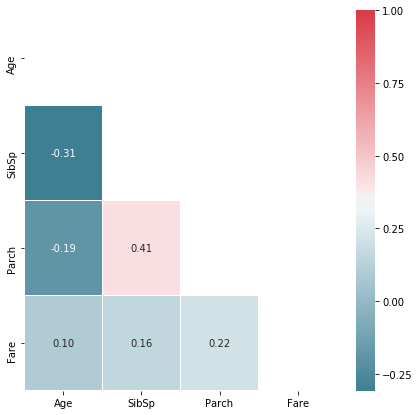

In [38]:
corr = train[['Age','SibSp','Parch','Fare']].corr()
fig, ax = plt.subplots(figsize = (7,7))
colormap = sns.diverging_palette(220, 10, as_cmap = True)
dropSelf = np.zeros_like(corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
colormap = sns.diverging_palette(220, 10, as_cmap = True)
sns.heatmap(corr, cmap = colormap, linewidth = .5, annot = True, fmt = ".2f", mask = dropSelf)
plt.show()

> There's no strong correlation between any two variables. The strongest correlation is between SibSp and Parch features (0.41)

In [39]:
from scipy.stats import chi2_contingency

for i in cat:
    val = chi2_contingency(pd.crosstab(train['Survived'], train[i]))
    print(f'P-value {i}: ', val[1])

P-value Pclass:  4.549251711298793e-23
P-value Sex:  1.1973570627755645e-58
P-value Embarked:  1.769922284120912e-06


> P values for features Sex, Embarked and Pclass are very low. So we can reject our Null Hypothesis which is these features are independent and have no relationship with target variable

> So these features contribute by providing some information.

## Data Cleaning

In [40]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

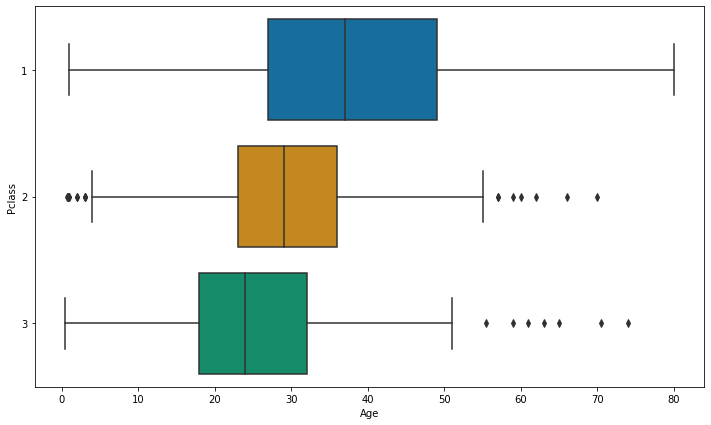

In [24]:
#Fill NaN Age with Mean of PClass
plt.figure(figsize = (12, 7))
sns.boxplot(x = 'Age', y = 'Pclass',orient = 'h', data = train, palette = 'colorblind')

In [25]:
train.groupby('Pclass').mean()

PassengerId  Survived        Age     SibSp     Parch       Fare
Pclass                                                                 
1        461.597222  0.629630  38.233441  0.416667  0.356481  84.154687
2        445.956522  0.472826  29.877630  0.402174  0.380435  20.662183
3        439.154786  0.242363  25.140620  0.615071  0.393075  13.675550

In [60]:
def fill_Age (cols):
    Age = cols[0]
    Pclass = cols[1]
    if pd.isna(Age):
        if Pclass == 1:
            return 38
        elif Pclass == 2:
            return 30
        else:
            return 25
    else:
        return Age

In [61]:
train.Age = train[['Age', 'Pclass']].apply(fill_Age, axis = 1)

In [204]:
train.Cabin.value_counts()

C23 C25 C27    4
B96 B98        4
G6             4
E101           3
D              3
              ..
B69            1
E36            1
B79            1
A16            1
E31            1
Name: Cabin, Length: 147, dtype: int64

In [62]:
cabin_only = train[['Cabin']].copy()
cabin_only['Cabin_Data'] = cabin_only['Cabin'].isnull().apply(lambda x: not x)

In [63]:
cabin_only['Deck'] = cabin_only['Cabin'].str.slice(0,1)
cabin_only[cabin_only['Cabin_Data']]

Cabin  Cabin_Data Deck
1            C85        True    C
3           C123        True    C
6            E46        True    E
10            G6        True    G
11          C103        True    C
..           ...         ...  ...
871          D35        True    D
872  B51 B53 B55        True    B
879          C50        True    C
887          B42        True    B
889         C148        True    C

[204 rows x 3 columns]

In [64]:
cabin_only['Deck'] = cabin_only['Deck'].fillna('N')

In [10]:
cabin_only.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 1 columns):
Deck    891 non-null object
dtypes: object(1)
memory usage: 7.1+ KB


In [11]:
cabin_only.isna().sum()

Deck    0
dtype: int64

In [65]:
train['Cabin'] = cabin_only['Deck']

In [66]:
train.Cabin.head()

0    N
1    C
2    N
3    C
4    N
Name: Cabin, dtype: object

In [159]:
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [67]:
train.Embarked = train.Embarked.fillna('S')

In [68]:
train['Family'] = train.apply(lambda x: x['SibSp']+ x['Parch'], axis = 1)

In [178]:
#Drop Name and Ticket, PassengerId
# train.drop(['Name','Ticket', 'PassengerId', 'Fare'], axis = 1, inplace = True)

In [212]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
Family         891 non-null int64
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [215]:
train.Family.value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: Family, dtype: int64

In [69]:
train.Pclass.unique()

array([3, 1, 2])

## Encode Categorical Features

In [73]:
# cols = train[['Sex','Embarked', 'Cabin', 'Pclass', 'Family']]
# for i in cols.columns:
#     if len(cols.groupby([i]).size()) > 2:
#          cols = pd.get_dummies(cols, prefix = [i], columns = [i])
# enc_train = pd.get_dummies(cols, drop_first = True)

enc_train = pd.get_dummies(train, drop_first = True, columns = ['Sex','Embarked', 'Cabin', 'Pclass', 'Family'])

In [74]:
enc_train = enc_train.drop(['Name','SibSp', 'Parch', 'Ticket', 'PassengerId', 'Fare'], axis = 1)

In [75]:
enc_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 23 columns):
Survived      891 non-null int64
Age           891 non-null float64
Sex_male      891 non-null uint8
Embarked_Q    891 non-null uint8
Embarked_S    891 non-null uint8
Cabin_B       891 non-null uint8
Cabin_C       891 non-null uint8
Cabin_D       891 non-null uint8
Cabin_E       891 non-null uint8
Cabin_F       891 non-null uint8
Cabin_G       891 non-null uint8
Cabin_N       891 non-null uint8
Cabin_T       891 non-null uint8
Pclass_2      891 non-null uint8
Pclass_3      891 non-null uint8
Family_1      891 non-null uint8
Family_2      891 non-null uint8
Family_3      891 non-null uint8
Family_4      891 non-null uint8
Family_5      891 non-null uint8
Family_6      891 non-null uint8
Family_7      891 non-null uint8
Family_10     891 non-null uint8
dtypes: float64(1), int64(1), uint8(21)
memory usage: 32.3 KB


In [77]:
X = enc_train.iloc[:,1:24]
y = enc_train.Survived

In [11]:
# from sklearn.preprocessing import LabelEncoder

# enc_sex = LabelEncoder().fit(train.Sex.unique())
# train.Sex = enc_sex.transform(train.Sex)

# enc_Embarked = LabelEncoder().fit(train.Embarked.unique())
# train.Embarked = enc_Embarked.transform(train.Embarked)

# enc_Pclass = LabelEncoder().fit(train.Pclass.unique())
# train.Pclass = enc_Pclass.transform(train.Pclass)


## Let's Splitting the Features

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

## Building a Logistic Regression Model

In [79]:
model_log = LogisticRegression()
model_log.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [80]:
Log_Pred = model_log.predict(X_test)

> ### Evaluation the Model

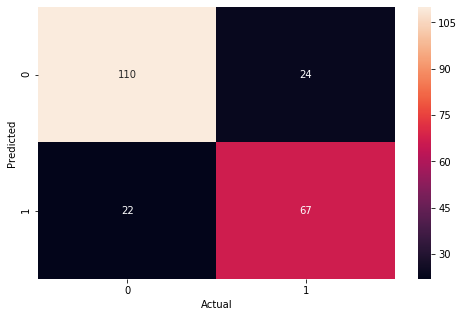

In [81]:
f, ax = plt.subplots(figsize = (8,5))
sns.heatmap(confusion_matrix(y_test, Log_Pred), annot = True, fmt = '.0f', ax = ax)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [82]:
print(classification_report(y_test, Log_Pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83       134
           1       0.74      0.75      0.74        89

    accuracy                           0.79       223
   macro avg       0.78      0.79      0.79       223
weighted avg       0.79      0.79      0.79       223



In [83]:
model_log.score(X_test, y_test)

0.7937219730941704

In [84]:
model_log.score(X_train, y_train)

0.8368263473053892

## Building a Decision Tree Classifier Model

In [85]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, y_train).tree_.node_count

333

In [86]:
DT_Pred = model_dt.predict(X_test)

In [94]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

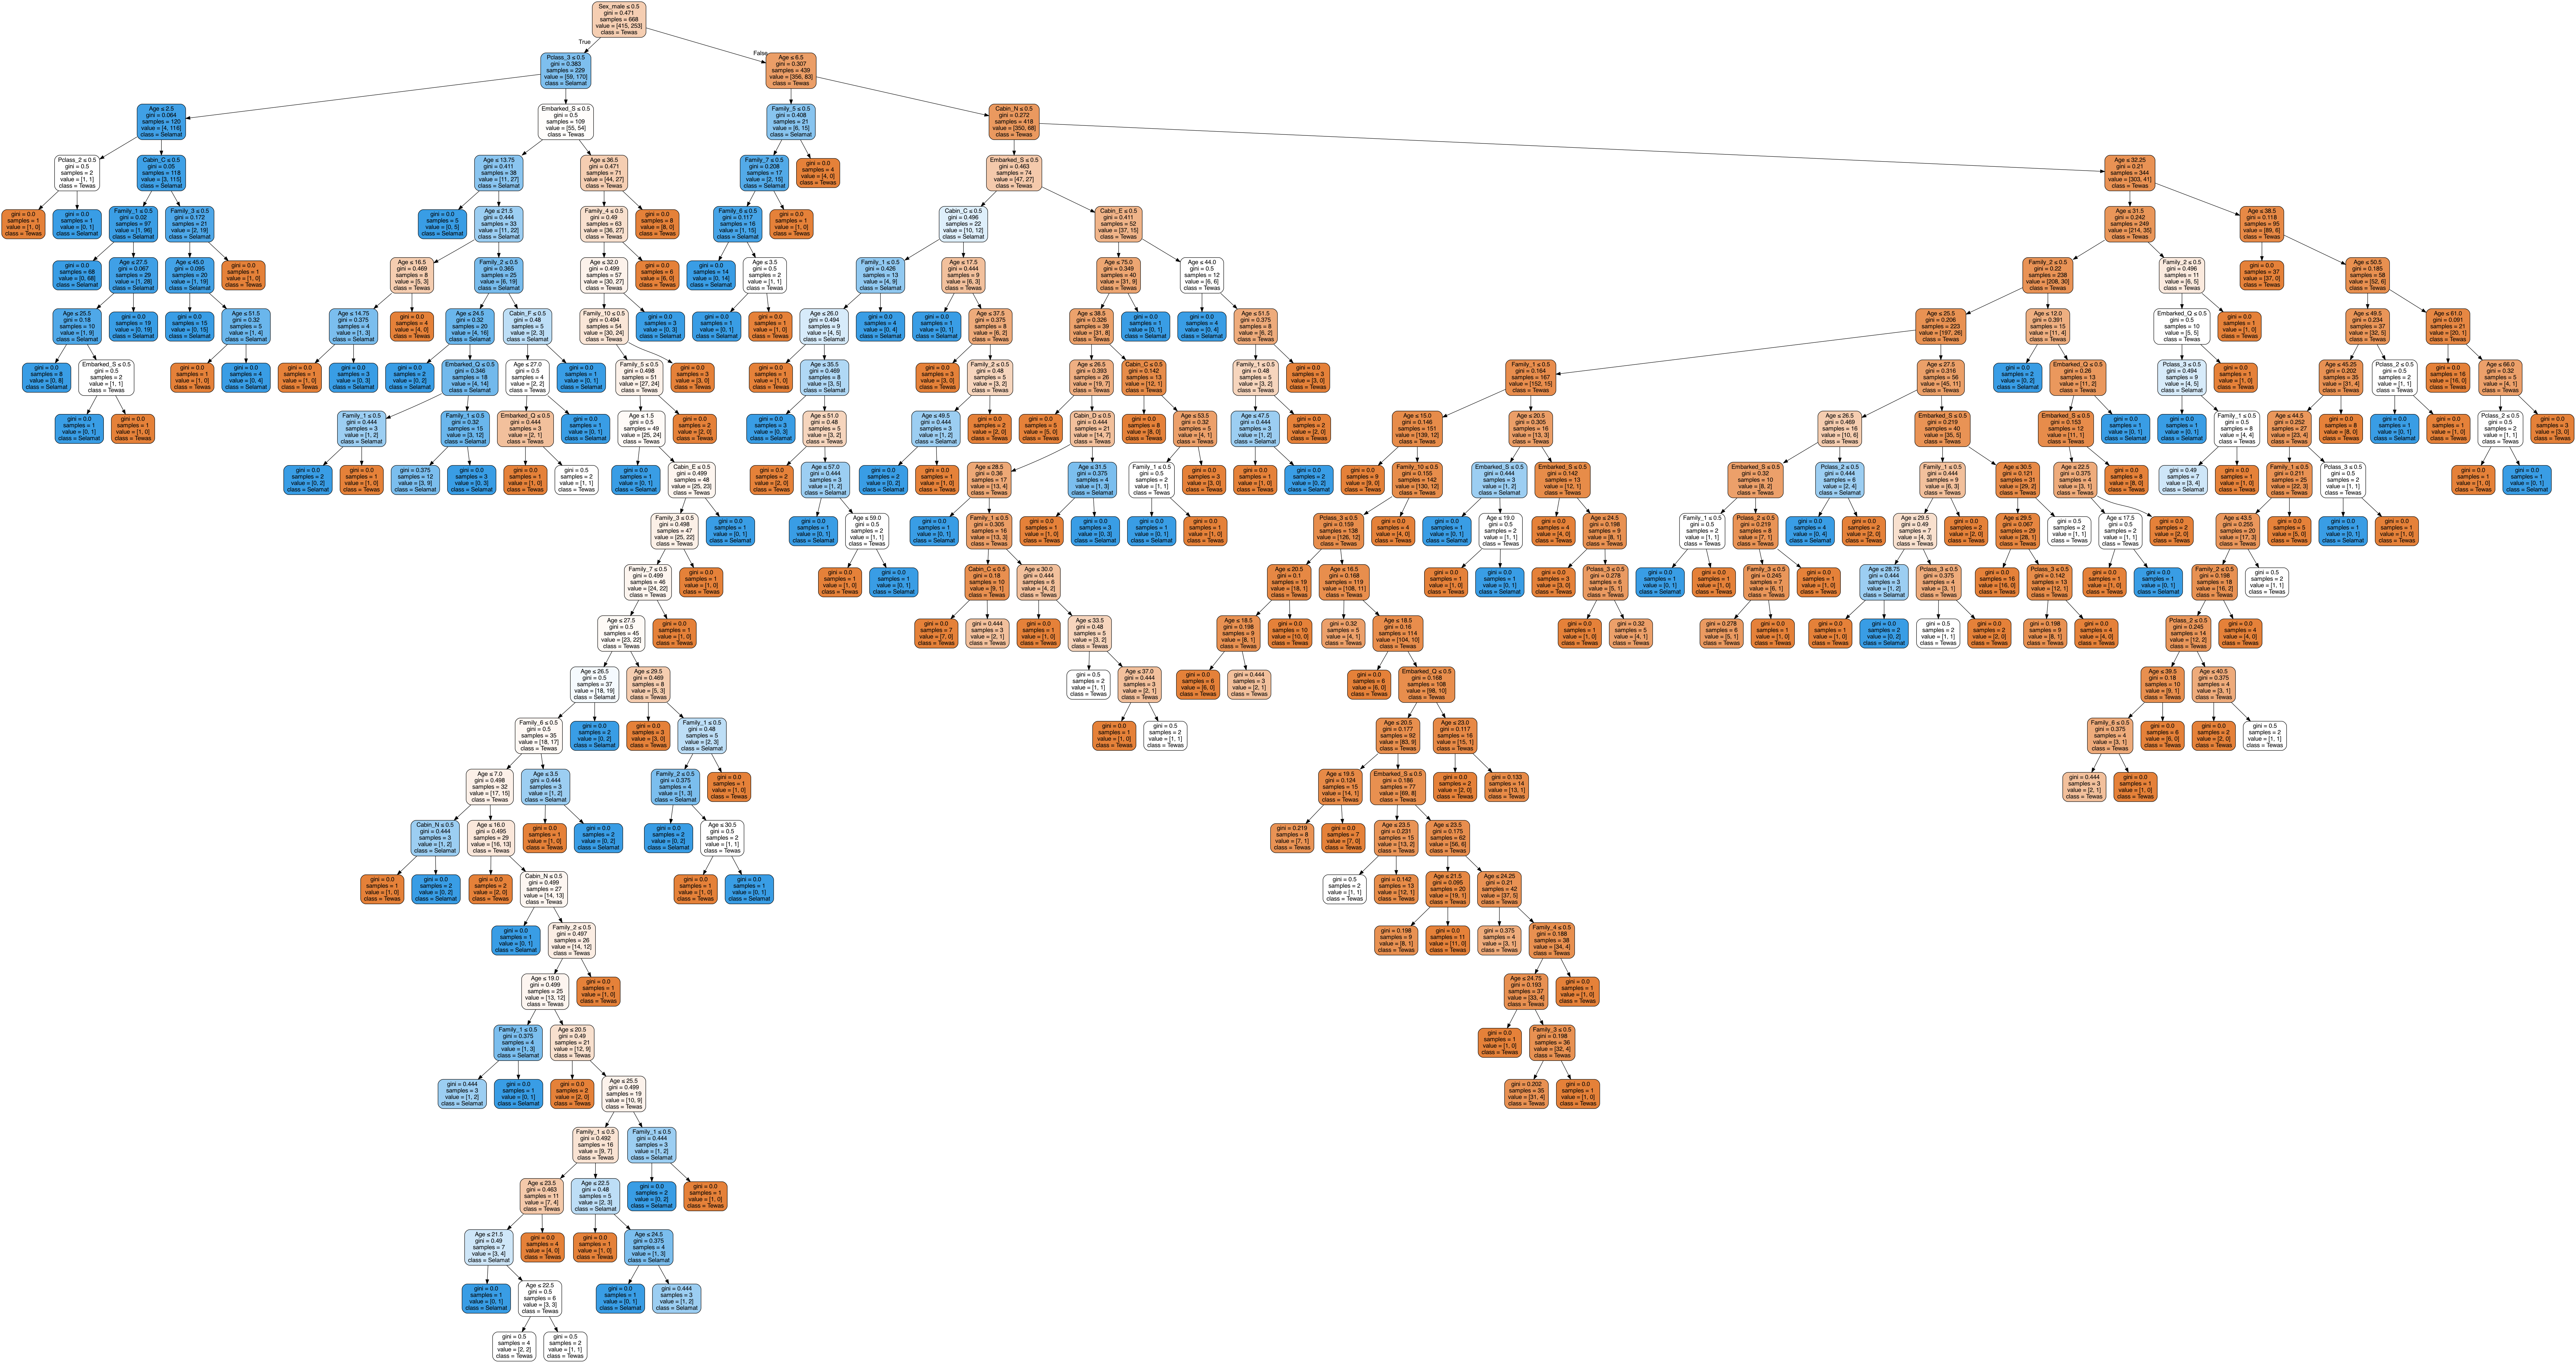

In [205]:
features = X_train.columns.tolist()
class_name = ['Tewas', 'Selamat']
dot_data = StringIO()
export_graphviz(model_dt, out_file = dot_data, feature_names = features,  
                filled = True, rounded = True,
                special_characters = True, class_names = class_name)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [208]:
dt = DecisionTreeClassifier(max_depth = 2)
dt.fit(X_train, y_train).tree_.node_count

7

In [195]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


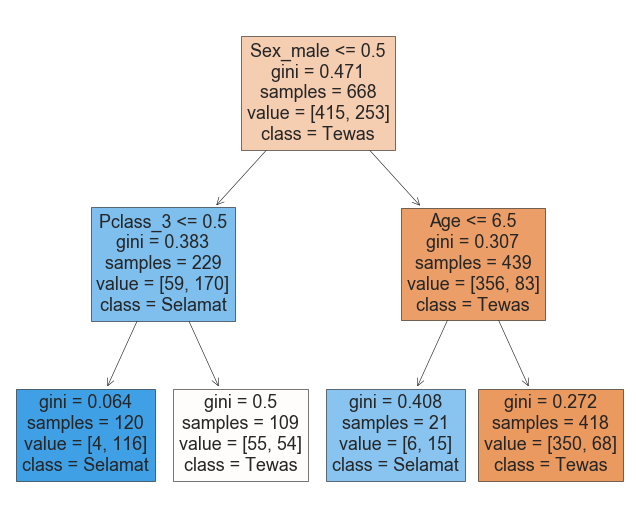

In [210]:
from sklearn.tree import plot_tree, export_text
plt.style.use('seaborn-poster')
plt.figure(figsize = (10, 8))
classes = ['Tewas', 'Selamat']
plot_tree(dt, feature_names = DT_columns, class_names = classes, filled = True);

In [211]:
print(export_text(dt, feature_names = DT_columns, show_weights = True))

|--- Sex_male <= 0.50
|   |--- Pclass_3 <= 0.50
|   |   |--- weights: [4.00, 116.00] class: 1
|   |--- Pclass_3 >  0.50
|   |   |--- weights: [55.00, 54.00] class: 0
|--- Sex_male >  0.50
|   |--- Age <= 6.50
|   |   |--- weights: [6.00, 15.00] class: 1
|   |--- Age >  6.50
|   |   |--- weights: [350.00, 68.00] class: 0



> ### Evaluation the Model

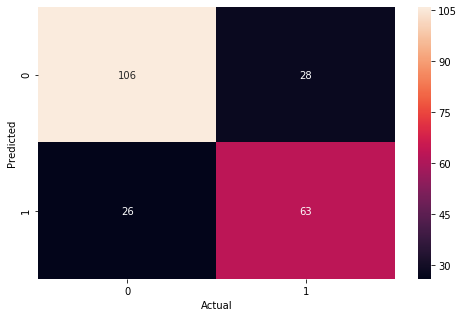

In [104]:
f, ax = plt.subplots(figsize = (8,5))
sns.heatmap(confusion_matrix(y_test, DT_Pred), annot = True, fmt = '.0f', ax = ax)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [105]:
print(classification_report(y_test, DT_Pred))

              precision    recall  f1-score   support

           0       0.80      0.79      0.80       134
           1       0.69      0.71      0.70        89

    accuracy                           0.76       223
   macro avg       0.75      0.75      0.75       223
weighted avg       0.76      0.76      0.76       223



In [106]:
model_dt.score(X_test, y_test)

0.757847533632287

In [107]:
model_dt.score(X_train, y_train)

0.9476047904191617

In [24]:
PredictProba = model_dt.predict_proba(X_test)


In [25]:
#If we want to adjust the treshold
predictions = []
for pred in PredictProba[:,0]:
    if(pred > 0.25):
        predictions.append(0)
    else:
        predictions.append(1)
        

## Building a Random Forest Classifier Model

In [108]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 100)]

# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(1, 11, num = 10)]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [111]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rfc, 
                               param_distributions = random_grid,
                               n_iter = 10, cv = 3, n_jobs = -1, scoring = 'accuracy')

In [112]:
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [113]:
rf_random.best_params_

{'n_estimators': 1800,
 'min_samples_split': 263,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': False}

In [114]:
model_rfc = RandomForestClassifier(n_estimators = 1800, min_samples_split = 263, min_samples_leaf =5,
                                   max_features = 'sqrt', max_depth = 20, bootstrap =False)

In [115]:
model_rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=263,
                       min_weight_fraction_leaf=0.0, n_estimators=1800,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [178]:
estimator = model_rfc.estimators_[1799]

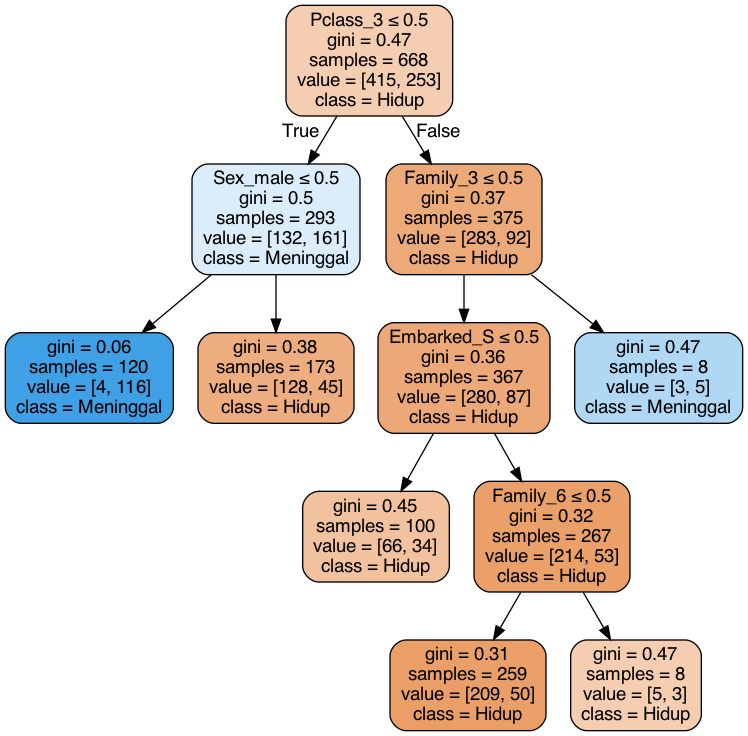

In [179]:
features = X_train.columns.tolist()
class_name = ['Hidup', 'Meninggal']
dot_data = StringIO()
export_graphviz(estimator, out_file = dot_data, feature_names = features, filled = True, 
                rounded = True, proportion = False, precision = 2,
                special_characters = True, class_names = class_name)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [119]:
RFC_Pred = model_rfc.predict(X_test)

> ### Evaluation the Model

In [117]:
model_rfc.score(X_test, y_test)

0.7847533632286996

In [118]:
model_rfc.score(X_train, y_train)

0.8233532934131736

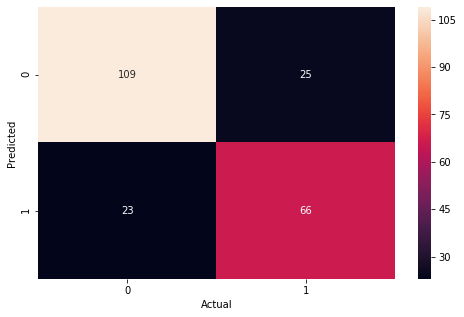

In [120]:
f, ax = plt.subplots(figsize = (8,5))
sns.heatmap(confusion_matrix(y_test, RFC_Pred), annot = True, fmt = '.0f', ax = ax)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [121]:
print(classification_report(y_test, RFC_Pred))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       134
           1       0.73      0.74      0.73        89

    accuracy                           0.78       223
   macro avg       0.78      0.78      0.78       223
weighted avg       0.79      0.78      0.79       223



## Let's Compare Models. Who's the Best?

In [122]:
from sklearn.metrics import plot_roc_curve, accuracy_score, auc, accuracy_score

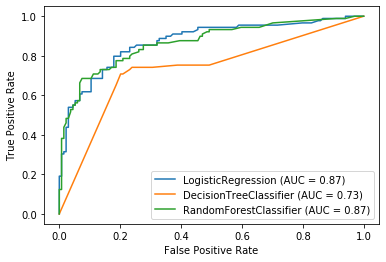

In [123]:
disp = plot_roc_curve(model_log, X_test, y_test)
plot_roc_curve(model_dt, X_test, y_test, ax = disp.ax_)
plot_roc_curve(model_rfc, X_test, y_test, ax = disp.ax_)

In [124]:
models = [model_log, model_dt, model_rfc]
accuracy_scores = []
for model in models:
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    
print(accuracy_scores)

[0.7937219730941704, 0.757847533632287, 0.7847533632286996]


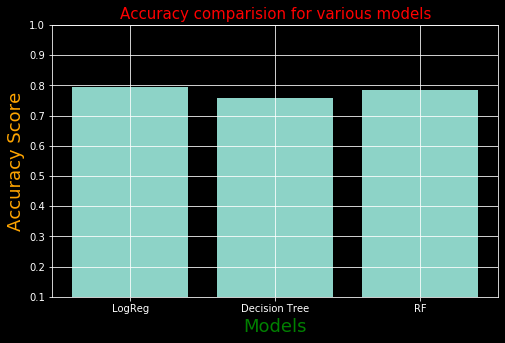

In [151]:
plt.figure(figsize = (8,5))
plt.bar(['LogReg', 'Decision Tree', 'RF'], accuracy_scores)
plt.grid()
plt.ylim(0.10,1.0)
plt.title('Accuracy comparision for various models', fontsize = 15, color = 'r')
plt.xlabel('Models', fontsize = 18, color = 'g')
plt.ylabel('Accuracy Score', fontsize = 18, color = 'orange')
plt.show()

### Features Importance

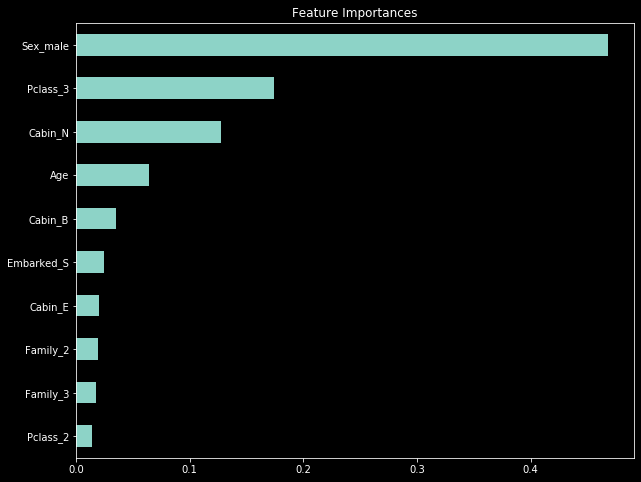

In [145]:
coef = pd.Series(model_rfc.feature_importances_, X_train.columns).sort_values(ascending = True).tail(10)
plt.figure(figsize = (10,8))
coef.plot(kind = 'barh', title = 'Feature Importances')

In [31]:
def cramers_v(x, y):
    import scipy.stats as ss
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


In [32]:
print('Pclass :', cramers_v(train.Pclass, train.Survived))
print('Age :', cramers_v(train.Age, train.Survived))
print('Sex :', cramers_v(train.Sex, train.Survived))
print('Embarked :', cramers_v(train.Embarked, train.Survived))
print('SibSp :', cramers_v(train.SibSp, train.Survived))
print('Parch :', cramers_v(train.Parch, train.Survived))


Pclass : 0.33385929315075563
Age : 0.18792713383688706
Sex : 0.5384179891641881
Embarked : 0.16605833339661635
SibSp : 0.18904284741068803
Parch : 0.1588028493486568


#### From categorical stats with cramers value, there is Pclass and Sex features has indicates strong 

#### association with Survived feature.